# 0.) Import the Credit Card Fraud Data From CCLE

In [74]:
import pandas as pd
#from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [75]:
#drive.mount('/content/gdrive/', force_remount = True)

In [76]:
#df = pd.read_csv("/content/gdrive/MyDrive/W24ML Code/Data/fraudTest.csv")
df = pd.read_csv("fraudTest.csv")

In [77]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [78]:
df_select = df[["trans_date_trans_time", "category", "amt", "city_pop", "is_fraud"]]

df_select["trans_date_trans_time"] = pd.to_datetime(df_select["trans_date_trans_time"])
df_select["time_var"] = [i.second for i in df_select["trans_date_trans_time"]]

X = pd.get_dummies(df_select, ["category"]).drop(["trans_date_trans_time", "is_fraud"], axis = 1)
y = df["is_fraud"]

# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [111]:
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size = .5)

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_holdout = scaler.transform(X_holdout)

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [113]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [114]:
ros = RandomOverSampler()
over_X, over_y = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler()
under_X, under_y = rus.fit_resample(X_train, y_train)

smote = SMOTE()
smote_X, smote_y = smote.fit_resample(X_train, y_train)

# 3.) Train three logistic regression models

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
over_log = LogisticRegression().fit(over_X, over_y)

under_log = LogisticRegression().fit(under_X, under_y)

smote_log = LogisticRegression().fit(smote_X, smote_y)

# 4.) Test the three models

In [117]:
over_log.score(X_test, y_test)

0.9183161784111903

In [118]:
under_log.score(X_test, y_test)

0.8934715324264018

In [119]:
smote_log.score(X_test, y_test)

0.9143213608771803

In [120]:
# We see SMOTE performing with higher accuracy but is ACCURACY really the best measure?

Accuracy score is not that important.We actually see that oversampling is performing better than undersampling etc., but performance wise they are all pretty much the same. The differences in performance we see here will likely change with a different random state, so essentially these differences don't matter all that much and accuracy isn't the best measure.

# 5.) Which performed best in Out of Sample metrics?

In [44]:
# Sensitivity here in credit fraud is more important as seen from last class

In [121]:
from sklearn.metrics import confusion_matrix

In [122]:
y_true = y_test

In [123]:
y_pred = over_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[76321,  6738],
       [   71,   228]])

In [124]:
print("Over Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Over Sample Sensitivity :  0.7625418060200669


In [125]:
y_pred = under_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[74245,  8814],
       [   66,   233]])

In [126]:
print("Under Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Under Sample Sensitivity :  0.7792642140468228


In [127]:
y_pred = smote_log.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[75986,  7073],
       [   69,   230]])

In [128]:
print("SMOTE Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

SMOTE Sample Sensitivity :  0.7692307692307693


# 6.) Pick two features and plot the two classes before and after SMOTE.

In [105]:
raw_temp = pd.concat([X_train, y_train], axis =1)

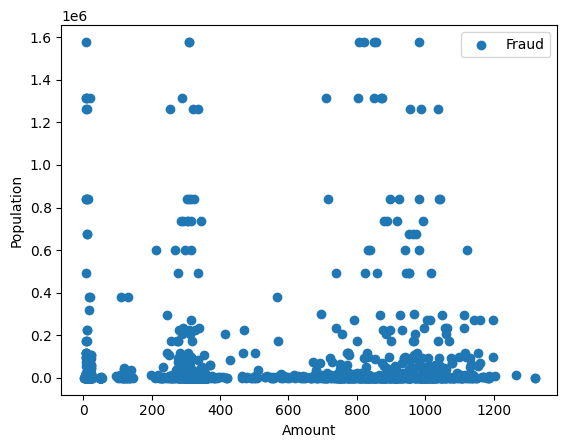

In [107]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend(["Fraud", "Not Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

In [108]:
raw_temp = pd.concat([smote_X, smote_y], axis =1)


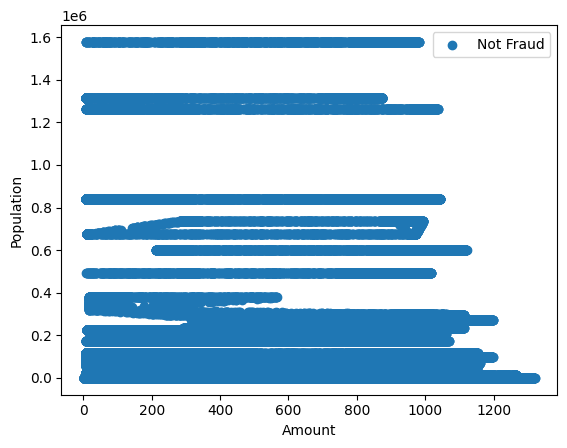

In [109]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend([ "Not Fraud", "Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

# 7.) We want to compare oversampling, Undersampling and SMOTE across our 3 models (Logistic Regression, Logistic Regression Lasso and Decision Trees).

# Make a dataframe that has a dual index and 9 Rows.
# Calculate: Sensitivity, Specificity, Precision, Recall and F1 score. for out of sample data.
# Notice any patterns across perfomance for this model. Does one totally out perform the others IE. over/under/smote or does a model perform better DT, Lasso, LR?
# Choose what you think is the best model and why. test on Holdout

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

In [141]:
    resampling_methods = {
        "over": RandomOverSampler(),
        "under": RandomUnderSampler(),
        "smote": SMOTE()

    }
    
    model_configs = {
        "LOG": LogisticRegression(),
        "LASSO": LogisticRegression(penalty = "l1",
                                   C = 2., solver = "liblinear"),
        "DTREE": DecisionTreeClassifier()
    }

In [145]:
def calc_perf_metric(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return(sensitivity, specificity, precision, recall, f1)

In [146]:
trained_models = {}
results = []

In [147]:
for resample_key, resampler in resampling_methods.items():
    resample_X, resample_y = resampler.fit_resample(X_train, y_train)
    
    for model_key, model in model_configs.items():
        combined_key = f"{resample_key}_{model_key}"
        
        m = model.fit(resample_X, resample_y)
        
        trained_models[combined_key] = m
        
        y_pred = m.predict(X_test)
        
        sensitivity, specificity, precision, recall, f1 = calc_perf_metric(y_test, y_pred)
        
        results.append({"Model": combined_key,
                        "Sensitivity": sensitivity, 
                        "Specificity": specificity,
                        "Precision": precision,
                        "Recall": recall,
                        "F1": f1 })
        
        #results.append(calc_perf_metric(y_test, y_pred))
        
    

In [149]:
results_df = pd.DataFrame(results)
results_df

,Model,Sensitivity,Specificity,Precision,Recall,F1
0,over_LOG,0.762542,0.919202,0.032858,0.762542,0.063001
1,over_LASSO,0.762542,0.919202,0.032858,0.762542,0.063001
2,over_DTREE,0.571906,0.998615,0.597902,0.571906,0.584615
3,under_LOG,0.759197,0.915771,0.031427,0.759197,0.060356
4,under_LASSO,0.762542,0.915313,0.031396,0.762542,0.060309
5,under_DTREE,0.959866,0.948892,0.063327,0.959866,0.118816
6,smote_LOG,0.765886,0.917252,0.032244,0.765886,0.061884
7,smote_LASSO,0.765886,0.917264,0.032249,0.765886,0.061892
8,smote_DTREE,0.719064,0.993222,0.276350,0.719064,0.399257


The "smote_DTREE" model has the highest F1 score, which indicates a good balance between precision and recall. It also has a decently high sensitivity and specificity (though its sensitivity is a little bit low compared to the others. 